In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install torch torchvision torchaudio

In [ ]:

%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import torch  # Importing PyTorch
import torchaudio  # Importing torchaudio for audio processing with PyTorch
from sklearn import model_selection, metrics  # Often used parts of scikit-learn


In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"

# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/MyDrive/SER Project/TESS'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        x, sr = librosa.load(path=os.path.join(subdir, file), sr=None)  # Load the audio file
        xt, index = librosa.effects.trim(x, top_db=30)  # Trim silence
        sample_lengths.append(len(xt))  # Append the length of trimmed audio

max_length = np.max(sample_lengths)
print('Maximum sample length:', max_length)

Maximum sample length: 131072


In [ ]:
import time
from pydub.effects import normalize

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 131072  # desired frame length for all of the audio samples
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/SER Project/TESS'

tic = time.perf_counter()

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        if 'TESS' in subdir:  # Ensure only processing TESS data
            # Fetch the sample rate
            _, sr = librosa.load(path=os.path.join(subdir, file), sr=None)  # Load the audio for sample rate
            # Load and normalize the audio
            rawsound = AudioSegment.from_file(os.path.join(subdir, file))
            normalizedsound = normalize(rawsound, headroom=0)
            # Convert audio to np.array
            normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
            # Trim silence
            xt, index = librosa.effects.trim(normal_x, top_db=30)
            # Pad trimmed audio to ensure uniformity
            padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
            # Noise reduction
            final_x = nr.reduce_noise(y=padded_x, sr=sr)

            # Feature extraction
            f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)
            f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length)
            f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)

            # Emotion extraction (TESS specific)
            emotion_code = find_emotion_T(file)
            if emotion_code != "-1":
                emotion_label = emotionfix(emotion_code)

            # Store features and labels
            rms.append(torch.tensor(f1))
            zcr.append(torch.tensor(f2))
            mfcc.append(torch.tensor(f3))
            emotions.append(emotion_label)

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

# Optionally convert lists to tensors for use in PyTorch models
rms_tensor = torch.stack(rms)
zcr_tensor = torch.stack(zcr)
mfcc_tensor = torch.stack(mfcc)
emotions_tensor = torch.tensor(emotions)

Running time: 15.5445 minutes


In [ ]:
# Convert lists to PyTorch tensors and ensure type is float32
f_rms = torch.tensor(rms_tensor, dtype=torch.float32)
f_zcr = torch.tensor(zcr_tensor, dtype=torch.float32)
f_mfccs = torch.tensor(mfcc_tensor, dtype=torch.float32)

# Permute dimensions to change shape from (samples, timesteps, features) to (samples, features, timesteps)
f_rms = f_rms.permute(0, 2, 1)
f_zcr = f_zcr.permute(0, 2, 1)
f_mfccs = f_mfccs.permute(0, 2, 1)

# Print the shapes to confirm correct reshaping
print('ZCR shape:', f_zcr.shape)
print('RMS shape:', f_rms.shape)
print('MFCCs shape:', f_mfccs.shape)

ZCR shape: torch.Size([5600, 257, 1])
RMS shape: torch.Size([5600, 257, 1])
MFCCs shape: torch.Size([5600, 257, 13])


<ipython-input-11-655b2d75b1ad>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_rms = torch.tensor(rms_tensor, dtype=torch.float32)
<ipython-input-11-655b2d75b1ad>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_zcr = torch.tensor(zcr_tensor, dtype=torch.float32)
<ipython-input-11-655b2d75b1ad>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_mfccs = torch.tensor(mfcc_tensor, dtype=torch.float32)


In [ ]:
# Assuming f_rms, f_zcr, and f_mfccs have been defined and reshaped as shown before

# Concatenating all features to 'X' variable in PyTorch
X = torch.cat((f_zcr, f_rms, f_mfccs), dim=2)

# Preparing 'Y' as a 2D shaped tensor
Y = torch.tensor(emotions_tensor, dtype=torch.int8).unsqueeze(1)

<ipython-input-12-fb3fa0e845a1>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(emotions_tensor, dtype=torch.int8).unsqueeze(1)


In [ ]:
from json_tricks import dump

# Convert tensors to lists
x_data = X.tolist()  # Convert tensor X to a list
y_data = Y.tolist()  # Convert tensor Y to a list

# Define file paths
x_path = '/content/drive/My Drive/Colab Notebooks/X1_dataTESSnew.json'  # File save path for X
y_path = '/content/drive/My Drive/Colab Notebooks/Y1_dataTESSnew.json'  # File save path for Y

# Dump data to JSON files
dump(obj=x_data, fp=x_path)
dump(obj=y_data, fp=y_path)

'[[6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

# Function to convert labels to one-hot encoded format
def to_one_hot(y, num_classes):
    y = y.long()  # Ensure the index tensor is of type long
    return torch.eye(num_classes)[y.squeeze()]

# Apply one-hot encoding
y_train_class = to_one_hot(y_train, 8)
y_val_class = to_one_hot(y_val, 8)

# Print shapes of the one-hot encoded tensors
print("Shape of y_train_class:", y_train_class.shape)
print("Shape of y_val_class:", y_val_class.shape)

Shape of y_train_class: torch.Size([4900, 8])
Shape of y_val_class: torch.Size([487, 8])


In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

torch.Size([4900, 257, 15])
torch.Size([487, 257, 15])
torch.Size([213, 257, 15])


LSTMModel(
  (lstm1): LSTM(15, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)
Epoch 0: Training Loss: 1.9420, Accuracy: 0.1665, Val Loss: 1.9936, Val Accuracy: 0.1992
Epoch 1: Training Loss: 1.6822, Accuracy: 0.2988, Val Loss: 2.4137, Val Accuracy: 0.1540
Epoch 2: Training Loss: 1.6344, Accuracy: 0.3108, Val Loss: 1.6186, Val Accuracy: 0.2977
Epoch 3: Training Loss: 1.5204, Accuracy: 0.3508, Val Loss: 1.5141, Val Accuracy: 0.3450
Epoch 4: Training Loss: 1.4945, Accuracy: 0.3702, Val Loss: 1.5569, Val Accuracy: 0.3634
Epoch 5: Training Loss: 1.4354, Accuracy: 0.3822, Val Loss: 1.4421, Val Accuracy: 0.4004
Epoch 6: Training Loss: 1.3995, Accuracy: 0.4039, Val Loss: 1.4846, Val Accuracy: 0.3470
Epoch 7: Training Loss: 1.4790, Accuracy: 0.3739, Val Loss: 1.7832, Val Accuracy: 0.2485
Epoch 8: Training Loss: 1.6252, Accuracy: 0.3249, Val Loss: 1.9980, Val Accuracy: 0.2546
Epoch 9: Training Loss: 1.4159, Accuracy: 0.

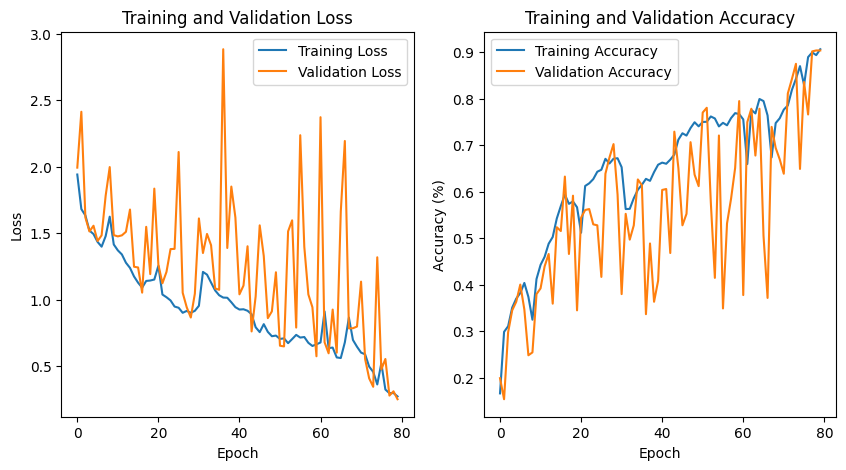

In [ ]:
from torch import nn
from torch.optim import RMSprop
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        # First LSTM layer, outputting all hidden states for batch sequences
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, batch_first=True)
        # Second LSTM layer, we'll only use the final hidden state
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        # Fully connected layer that outputs the class scores
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Process input through the first LSTM layer
        x, _ = self.lstm1(x)
        # Process the output of the first LSTM through the second LSTM
        x, _ = self.lstm2(x)
        # We use only the final hidden state to pass to the dense layer
        x = x[:, -1, :]  # Selecting the last timestep's output for classification
        # Pass through the fully connected layer and apply log_softmax for the output
        return torch.log_softmax(self.fc(x), dim=1)

# Assuming you have some example data `x_train`
# Model instantiation
input_size = x_train.shape[2]  # This should match the number of features in your input
hidden_dim = 64  # You can adjust the hidden dimensions
num_classes = 8  # Assuming 8 classes for classification

model = LSTMModel(input_size, hidden_dim, num_classes)
print(model)


from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss

# Optimizer and loss function
optimizer = RMSprop(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # Since we used log_softmax in the model

# Dataloader setup
#train_dataset = TensorDataset(x_train, y_train_class)
#train_loader = DataLoader(train_dataset, batch_size=23, shuffle=True)

#val_dataset = TensorDataset(x_val, y_val_class)
#val_loader = DataLoader(val_dataset, batch_size=23, shuffle=False)


# Assuming y_train_class and y_val_class are one-hot encoded, convert them like this:
y_train_indices = torch.max(y_train_class, 1)[1]
y_val_indices = torch.max(y_val_class, 1)[1]

# Then, recreate your DataLoader using these indices
train_dataset = TensorDataset(x_train, y_train_indices)
train_loader = DataLoader(train_dataset, batch_size=23, shuffle=True)

val_dataset = TensorDataset(x_val, y_val_indices)
val_loader = DataLoader(val_dataset, batch_size=23, shuffle=False)


# Assume model is already defined and set up
optimizer = RMSprop(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()  # Using CrossEntropyLoss which expects class indices

# Placeholder for collected data
loss_values = []        # Training losses
val_loss_values = []    # Validation losses
accuracy_values = []    # Training accuracy
val_accuracy_values = []# Validation accuracy

# Training and validation loop
best_val_accuracy = 0
for epoch in range(80):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_loss = running_loss / total_train
    epoch_accuracy = correct_train / total_train
    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss = val_running_loss / total
    val_accuracy = correct / total
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    print(f'Epoch {epoch}: Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

# After training
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

# Load the best model weights (optional)
model.load_state_dict(torch.load('best_model.pth'))

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Validation Loss: 0.3122, Validation Accuracy: 0.9035


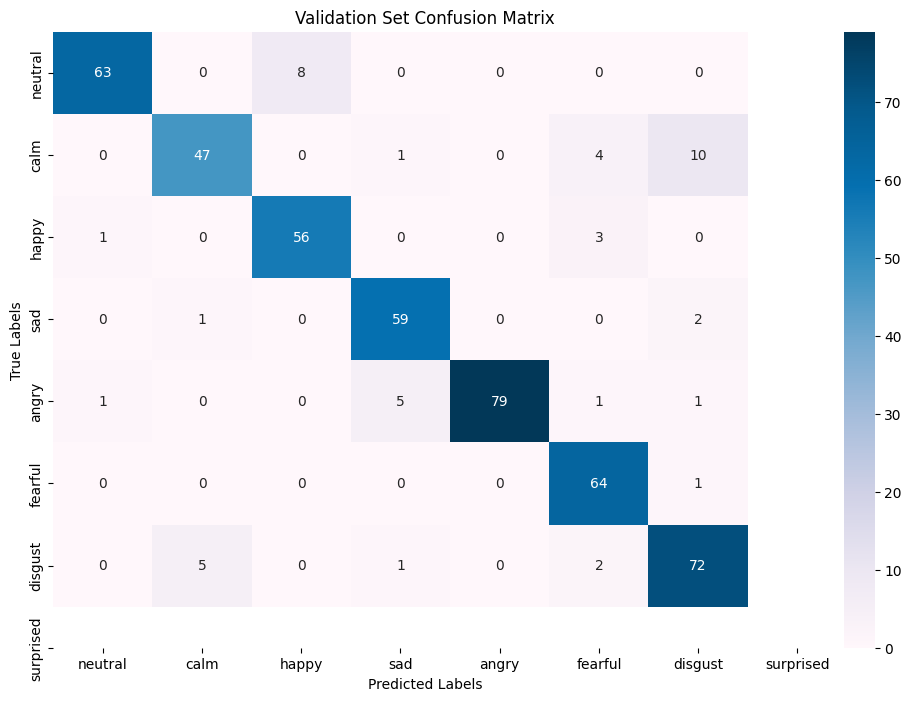

Validation set predicted class accuracy:
neutral: 88.73%
calm: 75.81%
happy: 93.33%
sad: 95.16%
angry: 90.80%
fearful: 98.46%
disgust: 90.00%


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Initialize to calculate loss and to collect true and predicted labels
val_losss = 0.0
correct = 0
total = 0
predictions = []
true_labels = []

# No need to calculate gradients
with torch.no_grad():
    for data, targets in val_loader:
        outputs = model(data)
        loss = criterion(outputs, targets)
        val_losss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate average loss and accuracy
val_losss /= total
val_accuracys = correct / total
print(f'Validation Loss: {val_losss:.4f}, Validation Accuracy: {val_accuracys:.4f}')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Plot confusion matrix
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap='PuBu', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Set Confusion Matrix')
plt.show()

# Calculate per-class accuracy from the confusion matrix
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)
print('Validation set predicted class accuracy:')
for i, acc in enumerate(class_accuracy):
    print(f"{classes[i]}: {acc:.2f}%")


In [ ]:
import torch

# After training, or at a checkpoint
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.pth'
torch.save(model.state_dict(), saved_model_path)
print("Model state saved to disk.")

# Optionally, save the entire model
saved_entire_model_path = '/content/drive/My Drive/Colab Notebooks/entire_model8723.pth'
torch.save(model, saved_entire_model_path)
print("Entire model saved to disk.")

# Initialize the model again
model = LSTMModel(input_size, hidden_dim, num_classes)

# Load the saved state dictionary
model.load_state_dict(torch.load(saved_model_path))
model.eval()  # Set the model to evaluation mode
print("Loaded model weights from disk.")

# Load the entire model directly
model = torch.load(saved_entire_model_path)
model.eval()  # Set the model to evaluation mode for testing or deployment
print("Loaded entire model from disk.")

Model state saved to disk.
Entire model saved to disk.
Loaded model weights from disk.
Loaded entire model from disk.


In [ ]:
# Converting test labels to one-hot encoding, if needed for other parts
y_test_class = to_one_hot(y_test, 8)

# Since CrossEntropyLoss does not use one-hot:
y_test_indices = torch.max(y_test_class, 1)[1] if y_test_class.ndim > 1 else y_test

# Preparing DataLoader
test_dataset = TensorDataset(x_test, y_test_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Shape of y_test_class:", y_test_class.shape)

Shape of y_test_class: torch.Size([213, 8])


Test Loss: 0.3773, Test Accuracy: 0.8732


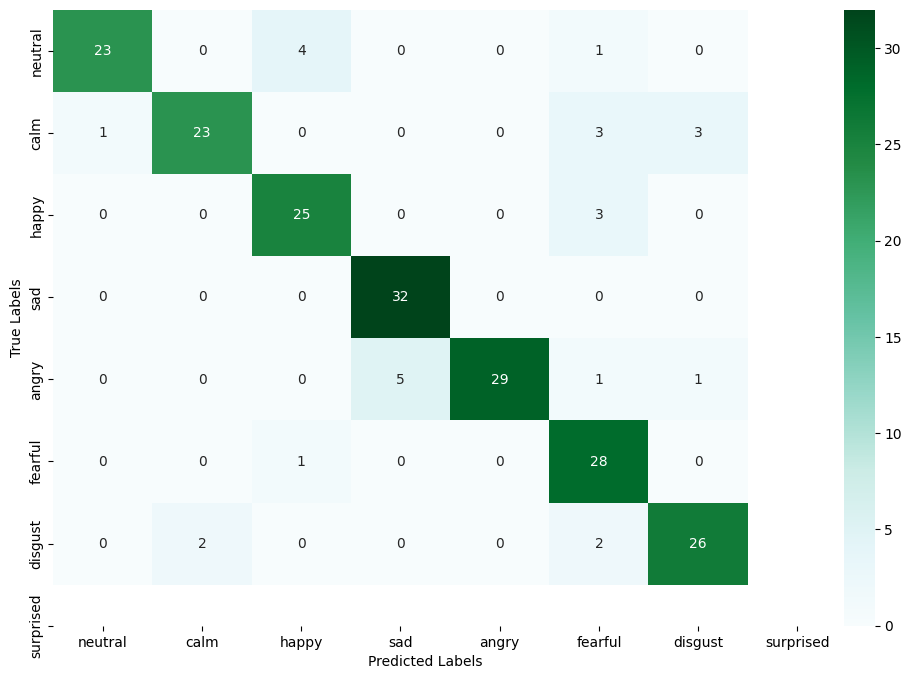

Test set predicted emotions accuracy:
neutral: 82.1429
calm: 76.6667
happy: 89.2857
sad: 100.0000
angry: 80.5556
fearful: 96.5517
disgust: 86.6667


In [ ]:
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

# Evaluate the model
total_loss = 0
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

avg_loss = total_loss / total
accuracy = correct / total
print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='BuGn', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Per-class accuracy
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)
print('Test set predicted emotions accuracy:')
for idx, acc in enumerate(class_accuracy):
    print(f"{classes[idx]}: {acc:.4f}")